In [1]:
import sqlite3
import pandas as pd
import matplotlib.dates as dates
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

import Cdf

In [2]:
params = {'axes.labelsize' : 14, 'axes.titlesize' : 14,
          'font.size' : 14, 'legend.fontsize' : 14,
          'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
plt.rcParams.update(params)

In [3]:
conn = sqlite3.connect('../data/mlab-data-aggregated.db')
mlab = pd.read_sql_query('select * from speedtest', con=conn, parse_dates=['dtime'])
conn.close()

In [4]:
mlab.tail()

,unit_id,dtime,address_v4,bytes_sec_v4,address_v6,bytes_sec_v6,delta_bytes_sec
404616,950236,2017-07-04 04:00:00,38.65.210.209,2384397,2001:550:1b01:1::209,1983686,400711
404617,950236,2017-07-04 10:00:00,38.65.210.209,2383833,2001:550:1b01:1::209,1761251,622582
404618,950238,2017-07-04 00:00:00,38.106.70.148,9943238,2001:550:1d00:100::148,11575193,-1631955
404619,950238,2017-07-04 06:00:00,38.106.70.148,11737390,2001:550:1d00:100::148,11575069,162321
404620,950238,2017-07-04 12:00:00,38.106.70.148,11737648,2001:550:1d00:100::148,11575340,162308


In [5]:
labels = ['delta_bytes_sec', 'bytes_sec_v4', 'bytes_sec_v6']

for label in labels:
    mlab[label] = mlab[label]/1024.0/1024.0  # MB/sec instead of B/sec 

In [6]:
mlab['dtime'] = mlab['dtime'].dt.floor('D')

In [7]:
df = mlab.groupby(['unit_id', 'dtime'], as_index=False
                    ).agg({'delta_bytes_sec' : 'median',
                           'bytes_sec_v4' : 'median',
                           'bytes_sec_v6' : 'median'}
                         )
df

,unit_id,dtime,delta_bytes_sec,bytes_sec_v4,bytes_sec_v6
0,19602,2014-09-05,-0.009107,0.173101,0.182479
1,19602,2014-09-06,0.002325,0.183606,0.182547
2,19602,2014-09-07,0.003207,0.186490,0.183088
3,19602,2014-09-08,0.003670,0.185117,0.180583
4,19602,2014-09-09,0.005003,0.185392,0.179770
...,...,...,...,...,...
51881,950240,2017-04-02,0.042490,2.961273,2.918777
51882,950240,2017-04-03,0.042854,2.961427,2.918595
51883,950240,2017-04-04,0.042495,2.960149,2.918262
51884,950240,2017-04-05,0.042400,2.960999,2.918501


In [8]:
df['year'] = df['dtime'].dt.year
df['month'] = df['dtime'].dt.month

In [9]:
by_years = df.groupby('year')

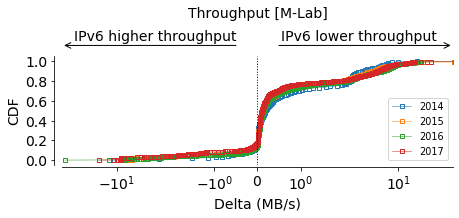

In [10]:
cdf_fig, cdf_ax = plt.subplots(figsize = (7, 2))

cdfs = []

for year, year_df in by_years:
    throughput = Cdf.MakeCdfFromList(year_df['delta_bytes_sec'])

    cdf_ax.plot(throughput.xs, throughput.ps, label = year, marker = 's',
                linewidth = 0.5, markersize = 3.5, fillstyle = 'none',
                markevery=15)

    cdfs.append((year, 'Throughput Deltas', throughput))

cdf_ax.set_ylim([-0.05, 1.05])
cdf_ax.set_xlabel('Delta (MB/s)')
cdf_ax.set_ylabel('CDF')
cdf_ax.set_xlim([-50, 50])
cdf_ax.set_xscale('symlog')

cdf_ax.legend(loc = 'lower right', fontsize = 'x-small')


yticks = np.arange(0.0, 1.01, 0.2)
cdf_ax.set_yticks(yticks)
cdf_ax.grid(False)
cdf_ax.spines['right'].set_color('none')
cdf_ax.spines['top'].set_color('none')
cdf_ax.yaxis.set_ticks_position('left')
cdf_ax.xaxis.set_ticks_position('bottom')
cdf_ax.spines['bottom'].set_position(('axes', -0.02))
cdf_ax.spines['left'].set_position(('axes', -0.02))

cdf_ax.set_title('Throughput [M-Lab]', y=1.3)

cdf_ax.axvline(x=0.0, linewidth=1.0, color='black', ls = 'dotted')

cdf_ax.annotate('', xy = (0.45, 1.1), xycoords = 'axes fraction', xytext = (0, 1.1), 
            arrowprops = dict(arrowstyle = "<-"))
cdf_ax.annotate('', xy = (1, 1.1), xycoords = 'axes fraction', xytext = (0.55, 1.1), 
                    arrowprops = dict(arrowstyle="->"))

cdf_ax.text(0.03, 1.15, "IPv6 higher throughput", transform=cdf_ax.transAxes)
cdf_ax.text(0.56, 1.15, "IPv6 lower throughput", transform=cdf_ax.transAxes)


cdf_fig.savefig('../plots/mlab-delta-throughput-by-year.pdf', bbox_inches = 'tight')
plt.show()

In [11]:
for year, version, cdf in cdfs:
    print(year, '\t\t', version)
    print('----------------')
    skip = int(len(cdf.xs)/150)
    for x, p in list(zip(cdf.xs, cdf.ps))[::skip]:
        print('%.2f\t\t%.5f' % (x, p))
    print('\n===========================\n')

2014 		 Throughput Deltas
----------------
-10.73		0.00039
-4.05		0.00671
-2.67		0.01302
-1.40		0.01933
-1.08		0.02564
-0.91		0.03195
-0.76		0.03826
-0.65		0.04458
-0.57		0.05089
-0.50		0.05720
-0.38		0.06351
-0.30		0.06982
-0.23		0.07613
-0.18		0.08245
-0.13		0.08876
-0.12		0.09507
-0.09		0.10138
-0.07		0.10769
-0.05		0.11400
-0.04		0.12032
-0.02		0.12663
-0.01		0.13294
-0.00		0.13925
0.00		0.14556
0.00		0.15187
0.00		0.15819
0.00		0.16450
0.00		0.17081
0.00		0.17751
0.00		0.18383
0.01		0.19053
0.01		0.20079
0.01		0.20710
0.01		0.21341
0.01		0.21972
0.01		0.22604
0.02		0.23274
0.02		0.23945
0.02		0.24576
0.02		0.25207
0.02		0.25838
0.02		0.26469
0.02		0.27140
0.02		0.27929
0.02		0.28718
0.02		0.29389
0.02		0.30020
0.02		0.30651
0.02		0.31282
0.02		0.31913
0.02		0.32544
0.03		0.33176
0.03		0.33807
0.03		0.34438
0.04		0.35069
0.04		0.35819
0.04		0.36489
0.05		0.37120
0.06		0.37751
0.07		0.38383
0.08		0.39014
0.08		0.39645
0.08		0.40276
0.08		0.40907
0.09		0.41538
0.10		0.42170
0.11		0.4

In [12]:
for year, year_df in by_years:
    print(year,'\n==================')
    print(
        year_df[['bytes_sec_v4', 'bytes_sec_v6']
               ].describe().iloc[-2])
    print('==================\n')

2014 
bytes_sec_v4    10.98682
bytes_sec_v6     9.35481
Name: 75%, dtype: float64

2015 
bytes_sec_v4    11.079931
bytes_sec_v6    10.022748
Name: 75%, dtype: float64

2016 
bytes_sec_v4    11.083829
bytes_sec_v6    10.684581
Name: 75%, dtype: float64

2017 
bytes_sec_v4    11.193573
bytes_sec_v6    10.998561
Name: 75%, dtype: float64



In [13]:
for year, year_df in by_years:
    print(year,'\n==================')
    print(
        year_df[['delta_bytes_sec']
               ].describe().iloc[-2])
    print('==================\n\n')

2014 
delta_bytes_sec    1.828031
Name: 75%, dtype: float64


2015 
delta_bytes_sec    0.97662
Name: 75%, dtype: float64


2016 
delta_bytes_sec    1.13294
Name: 75%, dtype: float64


2017 
delta_bytes_sec    0.734866
Name: 75%, dtype: float64


